In [1]:
import numpy as np
import time
from os import getcwd, path
from pathlib import Path
import pandas as pd

# np load error fix
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

from sys import path as sp
sp.append(path.join((Path.cwd()).parent,"scripts"))


# FPGA Initialisation

outputs: <br>
0: Grenade
1: Reload
2: Exit
3: Shield
4: IDLE
5: IGNORE

In [2]:
from filepaths import paths
from start_detector_tensor import Detector

In [3]:
fpga_detector = Detector()

# Falsify Data (Pre-live implementation of sensor)

In [4]:
from dataloader import get_real_testdata, load_to_df, unlink_DStore
from model_utils_training import scale_vals

In [5]:
testfiles=get_real_testdata()
train_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Activity_code']
test_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Activity_code']
targetfiles = testfiles
cols = test_cols

targetfiles = unlink_DStore(targetfiles)
targetfiles[:]

[PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_nds_test.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/test/IMU_nds_new_test.txt')]

In [6]:
train_classes = ['exit','reload','grenade','shield','idle']

idx = 1
df = load_to_df(targetfiles[idx:idx+1], cols)
df[train_cols[6]] = df[train_cols[6]].str.slice(start=0, stop=-1)
df = df[df['Activity_code'].isin(train_classes)]
df[cols[:6]] = df[cols[:6]].astype('int')
df = df[(df[cols[:6]] <= 255).all(axis=1)]
df = df[(df[cols[:6]] >= 0).all(axis=1)]

df['time']=[i+1 for i in range(df.shape[0])]

df_copy = df.copy()
timestep = 20
data = scale_vals(df_copy)

testing_class = [data.iloc[i].tolist()[:data.shape[1]-1] for i in range(data.shape[0])]

df_copy

,ax,ay,az,gx,gy,gz,Activity_code,time
0,0.447059,0.517647,0.713725,0.439216,0.474510,0.509804,idle,1
1,0.447059,0.517647,0.713725,0.439216,0.474510,0.509804,idle,2
2,0.466667,0.529412,0.705882,0.466667,0.458824,0.501961,idle,3
3,0.466667,0.529412,0.705882,0.466667,0.458824,0.501961,idle,4
4,0.474510,0.525490,0.709804,0.431373,0.466667,0.501961,idle,5
...,...,...,...,...,...,...,...,...
1792,0.317647,0.490196,0.470588,0.600000,0.482353,0.721569,reload,1653
1793,0.317647,0.490196,0.470588,0.600000,0.482353,0.721569,reload,1654
1794,0.329412,0.486275,0.470588,0.458824,0.474510,0.725490,reload,1655
1795,0.329412,0.486275,0.470588,0.458824,0.474510,0.725490,reload,1656


In [7]:
df_copy = df.copy()
timestep = 40

In [8]:
import matplotlib.pyplot as plt
from visualisers import plot_full_v2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


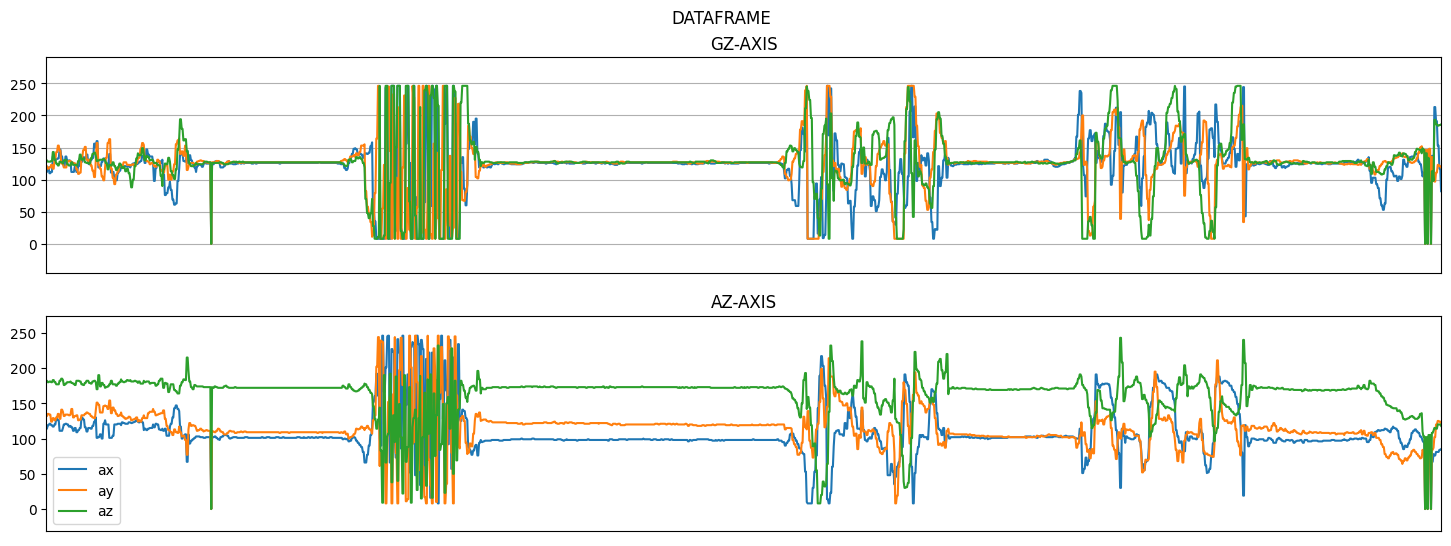

In [12]:
plot_full_v2(df_copy)

# Encode

In [8]:
from model_utils_training import encode, scale_vals, get_frames

In [9]:
df_copy, label = encode(df_copy)

print(label.classes_)
df_copy.head()

['exit' 'grenade' 'idle' 'reload' 'shield']


,ax,ay,az,gx,gy,gz,Activity_code,time,label
0,114,132,182,112,121,130,idle,1,2
1,114,132,182,112,121,130,idle,2,2
2,119,135,180,119,117,128,idle,3,2
3,119,135,180,119,117,128,idle,4,2
4,121,134,181,110,119,128,idle,5,2


In [10]:
data = scale_vals(df_copy)
ds_X = data[['ax','ay','az','gx','gy','gz']]
ds_Y = data['label']
scaled_X = pd.DataFrame(data=ds_X, columns=['ax','ay','az','gx','gy','gz'])
scaled_X['Activity_code'] = ds_Y.values
scaled_X

,ax,ay,az,gx,gy,gz,Activity_code
0,0.447059,0.517647,0.713725,0.439216,0.474510,0.509804,2
1,0.447059,0.517647,0.713725,0.439216,0.474510,0.509804,2
2,0.466667,0.529412,0.705882,0.466667,0.458824,0.501961,2
3,0.466667,0.529412,0.705882,0.466667,0.458824,0.501961,2
4,0.474510,0.525490,0.709804,0.431373,0.466667,0.501961,2
...,...,...,...,...,...,...,...
1792,0.317647,0.490196,0.470588,0.600000,0.482353,0.721569,3
1793,0.317647,0.490196,0.470588,0.600000,0.482353,0.721569,3
1794,0.329412,0.486275,0.470588,0.458824,0.474510,0.725490,3
1795,0.329412,0.486275,0.470588,0.458824,0.474510,0.725490,3


In [11]:
import scipy.stats as stats

In [14]:
seconds = 1
Fs = 40
frame_size = int(Fs*seconds/2) # 40 Hz * 1/2 (every half second check) = 20
hop_size = int(6*Fs/4) # hop every 5 steps

In [15]:
x, y = get_frames(scaled_X, frame_size, hop_size, labelled=True)
x.shape, y.shape

0 20
12 32
24 44
36 56
48 68
60 80
72 92
84 104
96 116
108 128
120 140
132 152
144 164
156 176
168 188
180 200
192 212
204 224
216 236
228 248
240 260
252 272
264 284
276 296
288 308
300 320
312 332
324 344
336 356
348 368
360 380
372 392
384 404
396 416
408 428
420 440
432 452
444 464
456 476
468 488
480 500
492 512
504 524
516 536
528 548
540 560
552 572
564 584
576 596
588 608
600 620
612 632
624 644
636 656
648 668
660 680
672 692
684 704
696 716
708 728
720 740
732 752
744 764
756 776
768 788
780 800
792 812
804 824
816 836
828 848
840 860
852 872
864 884
876 896
888 908
900 920
912 932
924 944
936 956
948 968
960 980
972 992
984 1004
996 1016
1008 1028
1020 1040
1032 1052
1044 1064
1056 1076
1068 1088
1080 1100
1092 1112
1104 1124
1116 1136
1128 1148
1140 1160
1152 1172
1164 1184
1176 1196
1188 1208
1200 1220
1212 1232
1224 1244
1236 1256
1248 1268
1260 1280
1272 1292
1284 1304
1296 1316
1308 1328
1320 1340
1332 1352
1344 1364
1356 1376
1368 1388
1380 1400
1392 1412
1404 1424
141

/Users/anderson/Desktop/github/capstoneml/scripts/model_utils_training.py:59: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(filt_df['Activity_code'][i: i + frame_size])[0][0]


((137, 20, 6), (137,))

# Load Model

In [20]:
import tensorflow as tf

In [21]:
model_name = 'cnn_monday_0'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model = tf.keras.models.load_model(MODEL_DIR)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 16)            304       
                                                                 
 dropout (Dropout)           (None, 18, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            2080      
                                                                 
 dropout_1 (Dropout)         (None, 15, 32)            0         
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 24)                11544     
                                                                 
 dropout_2 (Dropout)         (None, 24)                0

In [22]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [34]:
x[0:3]

array([[[0.44705882, 0.44705882, 0.46666667, 0.46666667, 0.4745098 ,
         0.4745098 ],
        [0.46666667, 0.46666667, 0.45882353, 0.45882353, 0.47058824,
         0.47058824],
        [0.50196078, 0.50196078, 0.49411765, 0.49411765, 0.43529412,
         0.43529412],
        [0.43529412, 0.43529412, 0.51764706, 0.51764706, 0.52941176,
         0.52941176],
        [0.5254902 , 0.5254902 , 0.48627451, 0.48627451, 0.50588235,
         0.50588235],
        [0.49411765, 0.49411765, 0.50980392, 0.50980392, 0.52941176,
         0.52941176],
        [0.50196078, 0.50196078, 0.55294118, 0.55294118, 0.71372549,
         0.71372549],
        [0.70588235, 0.70588235, 0.70980392, 0.70980392, 0.70588235,
         0.70588235],
        [0.71764706, 0.71764706, 0.70588235, 0.70588235, 0.69411765,
         0.69411765],
        [0.69411765, 0.69411765, 0.71372549, 0.71372549, 0.7254902 ,
         0.7254902 ],
        [0.43921569, 0.43921569, 0.46666667, 0.46666667, 0.43137255,
         0.43137255],

In [23]:
y_pred = model.predict(x)
classes_y = np.argmax(y_pred,axis=1)
chances = np.array([y_pred[i][np.argmax(y_pred[i])] for i in range(y_pred.shape[0])])

for i in range(chances.shape[0]):
    if chances[i] < 0.00:
        print("-", end=" ")
    elif classes_y[i] == 2:
        print("-", end=" ")
    else:
        print(classes_y[i], end=" ")

print("\nVERSUS\n")

for rv in y:
    if rv==2:
        print("-", end=" ")
    else:
        print(rv, end=" ")

6/6 [==============================] - 0s 720us/step
- - - - - - - - - - - - - - - 1 - - - - - - - - - - - - - - - - - - - - - 1 1 0 0 0 0 0 0 0 0 0 0 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 1 1 1 1 - - 1 - - 4 1 1 1 1 - - 1 4 - - - - - - - - - - - - - - 4 - 4 - - - 4 - 4 4 - - - 4 4 3 4 4 - - - - - - - - - - - - - - - - - - - - - - - 3 4 
VERSUS

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 0 0 0 0 0 0 0 0 0 0 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 1 1 1 1 1 - - - - 1 1 1 1 1 1 - - - - - - - - - - - - - - - - - 4 4 4 - - - - 4 4 4 - - - - - 4 4 4 - - - - - - - - - - - - - - - - - - - - - - - - - - 

2022-10-10 20:07:10.740943: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


/Users/anderson/Desktop/github/capstoneml/venv/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

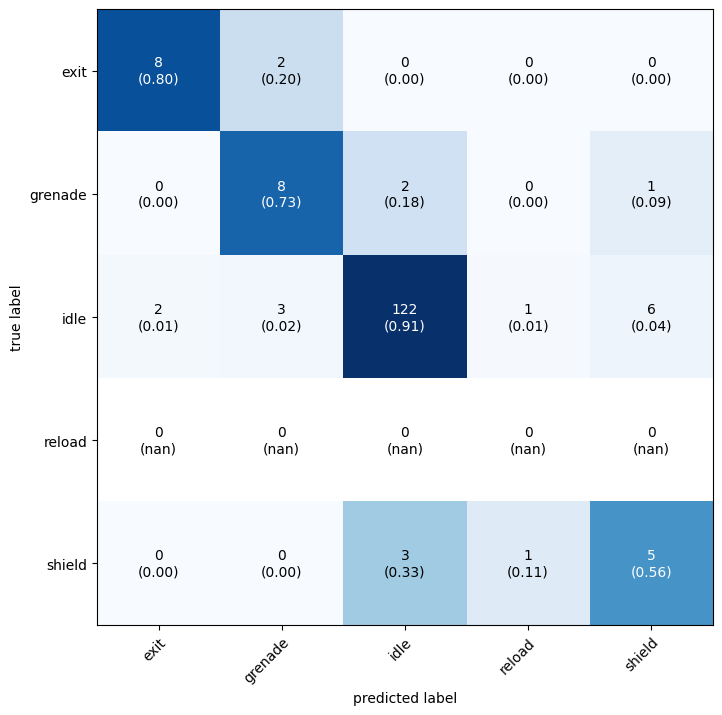

In [24]:
real_y = y
# real_y = Y_test

mat = confusion_matrix(real_y, classes_y)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True,figsize=(8,8))


In [30]:
file = open(targetfiles[0])
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[6].split(';')[0]
        last = last.strip()
        if last == '':
            break
        temp = [line[0], line[1], line[2], line[3], line[4], line[5], last]
        print(temp)

        if last == 'exit':
            print(i)
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

['106', '150', '173', '132', '124', '127', 'idle']
['105', '150', '173', '133', '126', '127', 'idle']
['105', '151', '173', '132', '127', '126', 'idle']
['105', '152', '173', '130', '127', '125', 'idle']
['105', '152', '174', '130', '126', '125', 'idle']
['105', '152', '173', '129', '126', '124', 'idle']
['106', '151', '173', '129', '127', '124', 'idle']
['105', '152', '174', '130', '128', '124', 'idle']
['105', '153', '173', '128', '128', '123', 'idle']
['105', '152', '174', '128', '127', '123', 'idle']
['105', '153', '175', '130', '127', '124', 'idle']
['104', '154', '175', '128', '128', '124', 'idle']
['102', '155', '176', '128', '127', '123', 'idle']
['102', '157', '175', '127', '123', '125', 'idle']
['103', '157', '175', '126', '121', '128', 'idle']
['104', '157', '175', '126', '121', '129', 'idle']
['104', '157', '175', '125', '122', '130', 'idle']
['104', '156', '176', '125', '122', '132', 'idle']
['104', '156', '175', '127', '123', '134', 'idle']
['105', '156', '174', '126', '1

[[[0.51764706 0.52156863 0.51764706 0.50980392 0.50980392 0.50588235]
  [0.50588235 0.50980392 0.50196078 0.50196078 0.50980392 0.50196078]
  [0.50196078 0.49803922 0.49411765 0.49411765 0.49019608 0.49019608]
  [0.49803922 0.49411765 0.48627451 0.49411765 0.49803922 0.49803922]
  [0.49411765 0.49411765 0.49803922 0.50196078 0.50196078 0.49803922]
  [0.49803922 0.50196078 0.49803922 0.48235294 0.4745098  0.4745098 ]
  [0.47843137 0.47843137 0.48235294 0.48235294 0.49803922 0.49803922]
  [0.49411765 0.49019608 0.49019608 0.48627451 0.48627451 0.48627451]
  [0.48235294 0.48235294 0.48627451 0.48627451 0.48235294 0.49019608]
  [0.50196078 0.50588235 0.50980392 0.51764706 0.5254902  0.52941176]
  [0.41568627 0.41176471 0.41176471 0.41176471 0.41176471 0.41176471]
  [0.41568627 0.41176471 0.41176471 0.41176471 0.41176471 0.40784314]
  [0.4        0.4        0.40392157 0.40784314 0.40784314 0.40784314]
  [0.40784314 0.41176471 0.58823529 0.58823529 0.59215686 0.59607843]
  [0.59607843 0.5960